In [ ]:
!curl -LJO https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/TA136.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6109  100  6109    0     0  25276      0 --:--:-- --:--:-- --:--:-- 25348


In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Para que las tablas se vean mejor
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
df = pd.read_csv("TA136.csv")   # Asegurate que el archivo esté en el mismo directorio del notebook
df = df.replace({0:0, 1:1})     # Por si vienen como strings
df = df.apply(pd.to_numeric, errors='coerce')  # Convierte todo y pone NaN donde no es numérico
df = df.drop(columns=["Unnamed: 0"])
df.head()

,item 0,item 1,item 2,item 3,item 4,item 5,item 6,item 7,item 8,item 9,item 10,item 11,item 12,item 13,item 14,item 15,item 16,item 17,item 18,item 19
0,1.0,0.0,1.0,NaN,0.0,0.0,1.0,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,1.0,0.0,0.0,NaN,0.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0
2,1.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0


##Modelo

Defino el modelo bayesiano planteando primero la distribución a priori de las medias $\mu \sim N(0, 1)$ y los desvíos $\sigma \sim \exp{(1)}$. Luego el parámetro de conocimiento $\theta \sim N(\mu_\theta, \sigma_\theta)$ y el de dificultad $\beta \sim N(\mu_\beta, \sigma_\beta)$.

Por último, la aprobación de una actividad va a estar dada por una Bernoulli de probabilidad $\sigma(\theta - \beta)$ (cuanto más fácil una tarea y más sepa el alumno, mas probabilidad de aprobar)

###PyMC

PyMC realiza inferencia bayesiana a través del algoritmo MCMC NUTS, definiendo directamente la red y usando los datos conocidos para calcular las posterioris. El beneficio de NUTS es que ajusta durante la iteración la dirección y el tamaño de los pasos en base a si los pasos que va haciendo son aceptados o no (en esto influye el target_accept)

In [ ]:
n_users, n_tasks = df.shape

with pm.Model() as model:
    # Hiperprioris
    mu_theta = pm.Normal("mu_theta", mu=0, sigma=1)
    mu_beta  = pm.Normal("mu_beta",  mu=0, sigma=1)

    sigma_theta = pm.Exponential("sigma_theta", lam=1)
    sigma_beta  = pm.Exponential("sigma_beta",  lam=1)

    # Prioris individuales
    theta = pm.Normal("theta", mu=mu_theta, sigma=sigma_theta, shape=n_users)
    beta  = pm.Normal("beta",  mu=mu_beta,  sigma=sigma_beta,  shape=n_tasks)

    # Probabilidad de acierto
    p = pm.Deterministic("p", pm.math.sigmoid(theta[:, None] - beta[None, :]))

    # Observaciones con datos faltantes ignorados (máscara automática)
    X_obs = pm.Bernoulli("X_obs", p=p, observed=df.values)

    model_pymc = model


/usr/local/lib/python3.12/dist-packages/pymc/model/core.py:1305: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/usr/local/lib/python3.12/dist-packages/pymc/model/core.py:1319: ImputationWarning: Data in X_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


## Grafico

Se ve que pymc divide entre los datos observados y no, tratando a los NaN como variables aleatorias que se pueden predecir luego al estimar los $\theta$ y $\beta$. Finalmente se juntan los resultados de las observadas y no observadas en

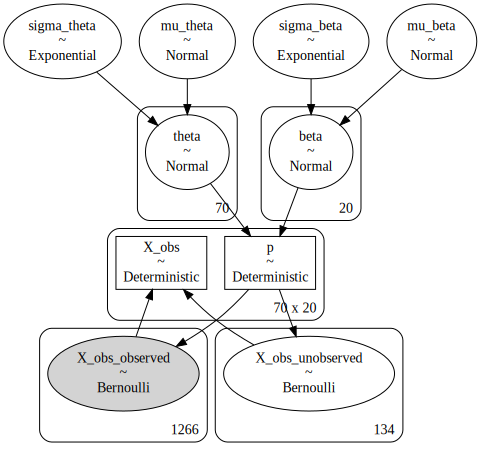

In [ ]:
pm.model_to_graphviz(model_pymc)


## Muestreo

Se muestrea para poder estimar la distribución a posteriori de los parámetros.

El argumento tune controla el periodo de adaptación del sampler, en el cual no se guardan muestras sino que se ajusta el tamaño de salto y se espera que el algoritmo se haya estabilizado.
Una vez completado este periodo, se generan las draws, que son las muestras utilizadas para estimar los parámetros.
El parámetro target_accept regula la tasa de aceptación deseada: valores altos (≈0.9) proporcionan mayor estabilidad a costa de mayor tiempo de cómputo, ya que más pasos se irán rechazando y por lo tanto el algoritmo va a ser más conservador.



Para corroborar que se convergió a la distribución correcta de evalúan dos parámetros. Uno es $\hat{R}$ que representa la similitud entre la convergencia de varias cadenas, esto se evalúa ya que cada cadena arranca con diferentes valores iniciales y por lo tanto podrían tener convergencias distintas.Se confirma que todas las cadenas convergieron adecuadamente si la varianza de cada cadena es similar a la varianza entre ellas, por lo que $\hat{R}$ es el cociente entre estas magnitudes.

Otro parámetro es el $ESS$ que es el effective sample size y nos dice cuantos datos independientes son necesarios para confirmar que la varianza del promedio de los datos es igual a la que se tendría si todos fueran independientes, esto asegura ergodicidad, lo que significa que se puede estimar la esperanza a partir del promedio.

In [ ]:
with model_pymc:
    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        chains=3,
        random_seed=2,
        cores = 3
    )

summary = az.summary(trace, var_names=["theta", "beta", "mu_theta", "mu_beta", "sigma_theta", "sigma_beta"])


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


(30.0, 100.0)

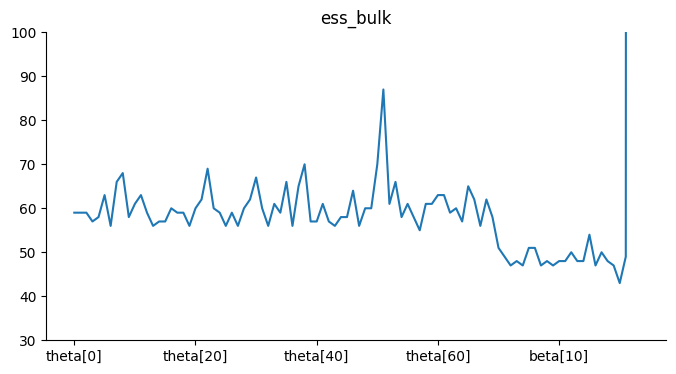

In [ ]:
from matplotlib import pyplot as plt
summary['ess_bulk'].plot(kind='line', figsize=(8, 4), title='ess_bulk')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.ylim([30,100])

(0.0, 1.1)

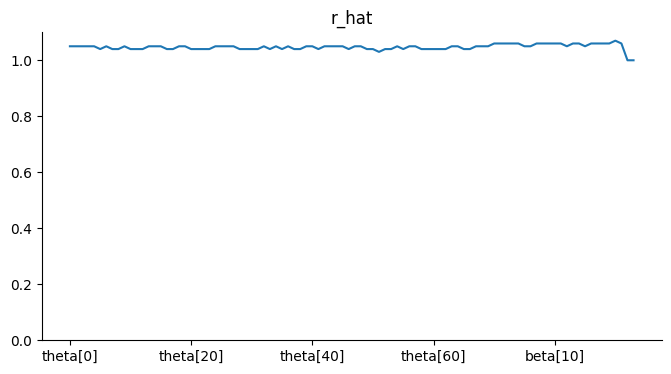

In [ ]:
from matplotlib import pyplot as plt
summary['r_hat'].plot(kind='line', figsize=(8, 4), title='r_hat')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.ylim([0,1.1])

## Estimación

Con las muestras a posteriori puede sacarse el promedio para estimar la esperanza de $\theta$ y $\beta$ para cada tarea y usuario.

Una vez teniendo los valores esperados, se puede decidir cuales son las tareas más y menos difíciles y los usuarios que más o menos saben.

In [ ]:
theta_mean = trace.posterior["theta"].mean(dim=("chain","draw")).values
beta_mean  = trace.posterior["beta"].mean(dim=("chain","draw")).values

usuario_mejor  = np.argmax(theta_mean)
usuario_peor   = np.argmin(theta_mean)
tarea_mas_facil = np.argmin(beta_mean)
tarea_mas_dificil = np.argmax(beta_mean)

print("Usuario mejor desempeño:", usuario_mejor)
print("Usuario peor desempeño:", usuario_peor)
print("Tarea más fácil:", tarea_mas_facil)
print("Tarea más difícil:", tarea_mas_dificil)


Usuario mejor desempeño: 51
Usuario peor desempeño: 50
Tarea más fácil: 0
Tarea más difícil: 15


## Distribuciones

Se observa que a posteriori las distribuciones para los parámetros que definen la media $\beta$ y $\theta$ tienen similitud con la distribución normal, en concordancia con las distribuciones a priori propuestas. Por otro lado, los desvíos si bien a simple vista podrían parecer una normal también tienen cierta similitud con la exponencial propuesta a priori, sobre todo en su media que se acerca a 1/$\lambda$ = 1.

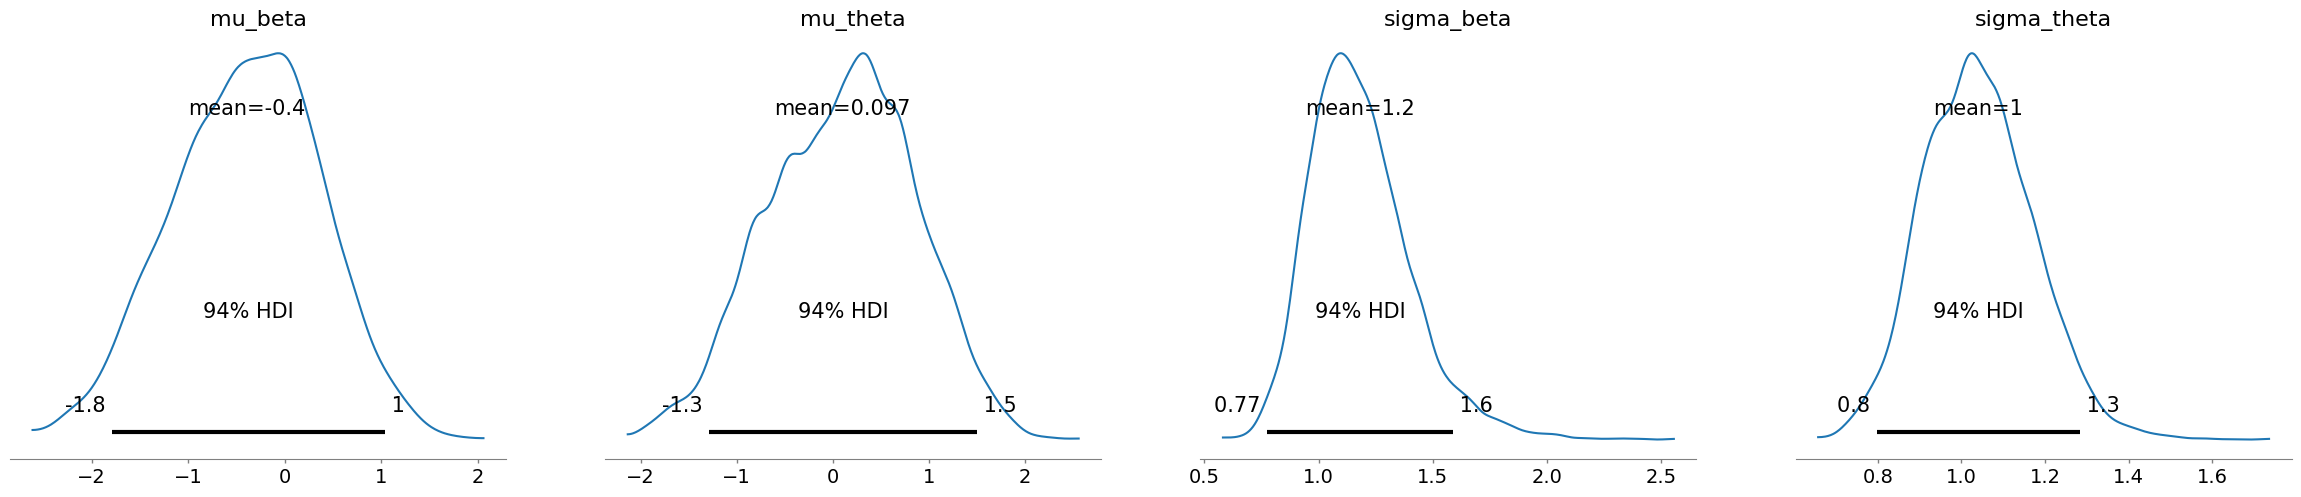

In [ ]:
az.plot_posterior(
    trace,
    var_names=["mu_theta", "mu_beta", "sigma_theta", "sigma_beta"],
    filter_vars="like"
)
plt.show()



## Probabilidad de aprobación

Con las muestras sobre $\theta$ y $\beta$ puedo estimar si cierto usuario aprobó cierta tarea, dado que cada cadena tiene muestras distintas, cada una debería dar una probabilidad levemente diferente. Se observa que estos valores son coincidentes dado que las cadenas convergen a distribuciones a posteriori similares.

In [ ]:
theta_samples = trace.posterior["theta"][:,:,4].values   # Convertir a NumPy
beta_samples  = trace.posterior["beta"][:,:,12].values

for c in range(3):
    prob_chain = 1 / (1 + np.exp(-(theta_samples[c] - beta_samples[c])))
    print(f"Cadena {c+1}: probabilidad ≈ {prob_chain.mean():.3f}")

Cadena 1: probabilidad ≈ 0.873
Cadena 2: probabilidad ≈ 0.872
Cadena 3: probabilidad ≈ 0.870
